# Capstone Project - Which Shoe is the Best for You?

General Assembly passion project. Scrape or obtain data from resources online to develop a dataset to perform cleaning, EDA, and analysis on. Try to predict a model on common themes like: 

- Price
- If item is in category A or B
- Cluster and create groups
- Recommender

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import urllib
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from time import sleep, strftime
import ast
from os import listdir

% matplotlib inline

**Testing one website and finding appropriate keys**

Then run again on page 2.

In [2]:
result = requests.get('https://stockx.com/api/browse?page=1&category=152')
json_res = result.json()

# print json_res['Products'][0]['shortDescription']
# print json_res['Products'][0]['retailPrice']

In [3]:
result = requests.get('https://stockx.com/api/browse?page=2&category=152')
json_res = result.json()

print json_res['Products'][0]['shortDescription']
print json_res['Products'][0]['retailPrice']

Adidas-Ultra-Boost-3pt0-Black-Silver
200


In [4]:
json_res['Products'][0]['market']

{u'absChangePercentage': 0.06,
 u'annualHigh': 350,
 u'annualLow': 200,
 u'averageDeadstockPrice': 269,
 u'averageDeadstockPriceRank': 68,
 u'changePercentage': -0.06,
 u'changeValue': -15,
 u'createdAt': u'2017-03-09T04:54:57+00:00',
 u'deadstockRangeHigh': 246,
 u'deadstockRangeLow': 224,
 u'deadstockSold': 1039,
 u'deadstockSoldRank': 64,
 u'highestBid': 235,
 u'lastHighestBidTime': 1498590170,
 u'lastLowestAskTime': 1498556369,
 u'lastSale': 235,
 u'lastSaleDate': u'2017-06-28T15:20:44+00:00',
 u'lowestAsk': 175,
 u'pricePremium': 0.175,
 u'pricePremiumRank': 88,
 u'productId': 0,
 u'productUuid': u'aef2f1ce-208f-4057-a244-78113339e8d0',
 u'salesLast72Hours': 36,
 u'salesLastPeriod': 0,
 u'salesThisPeriod': 36,
 u'skuUuid': None,
 u'updatedAt': 1498663269,
 u'volatility': 0.04515}

### Functions to run for loop to scrape website

First function scrapes the web for an amount of pages (default 50). It will save the raw data as a csv as well. The second function will then clean the dataframe by taking out the unused columns.

In [5]:
def shoe_scraper(pages=50):
    '''Returns one dataframe of all results. 
    And will save into a new file.'''
    
    # Have to run requests first to get appropriate column names
    req = requests.get('https://stockx.com/api/browse?page=1&category=152')
    json_req = req.json()
    df = pd.DataFrame([], columns=json_req['Products'][0].keys())

    for i in range(1,pages):
        try:
            html = 'https://stockx.com/api/browse?page=' + str(int(i)) + '&category=152'
            result = requests.get(html)
            json_res = result.json()
            df = pd.concat([df, pd.DataFrame(json_res['Products'])])
            sleep(0.5)
        except:
            break
    
    # Drop row duplicates
    df.drop_duplicates(['shortDescription', 'urlKey'], inplace=True) 
    
    # Function to save as csv file under today's day as raw (before dropping)
    def csv_maker(df):
        filename = 'StockX_' + strftime("%m%d%H")
        df.to_csv(path_or_buf='C:\\Users\\Chris\\Desktop\\dsi-atl-3\\project\\Capstone\\datasets\\' + filename, encoding='utf-8')
    
    csv_maker(df)
    
    return df

In [47]:
def clean_df(busy_dataframe):
    '''Dropping columns that hold little to no information.
    Then reset the index since we are getting repeated indices'''
    
    # Market DataFrame. If scraping, comes in ready form
    # If pulling from old data, dictionary comes in string form
    if isinstance(busy_dataframe.market.reset_index(drop=True)[0], str):
        market_df = pd.DataFrame([ast.literal_eval(row) for row in busy_dataframe['market']])
    else:
        market_df = pd.DataFrame([row for row in busy_dataframe['market']])
    
    # Drop unnecessary columns
    cleaner_dataframe = busy_dataframe.join(market_df)
    
    cleanest_dataframe = cleaner_dataframe.drop(['breadcrumbs', 'childId', 'countryOfManufacture', 'type', 
        'uuid', 'dataType', 'doppelgangers', 'condition', 'description', 'hidden', 'ipoDate', 'productCategory', 
        'shoeSize', 'urlKey', 'charityCondition', 'releaseTime', 'shortDescription', 'media', '_highlightResult', 
        'market', '_tags', 'id', 'objectID', 'lastHighestBidTime', 'lastLowestAskTime', 'styleId', 'productId',
        'productUuid', 'skuUuid', 'updatedAt', 'traits', 'tickerSymbol', 'salesLastPeriod',
        'minimumBid', 'averageDeadstockPriceRank', 'deadstockSoldRank', 'pricePremium', 'pricePremiumRank',
        'salesThisPeriod'], axis=1)
    
    # Remember title = shoe + name
    
    # Reset the index, since we are getting repeated indices
    cleanest_dataframe.reset_index(drop=True, inplace=True)
    
    return cleanest_dataframe

In [7]:
scraped_shoe = shoe_scraper()

In [46]:
def read_and_clean(path):
    '''Read a file path where datasets are stored. Cleans the dataframe by
    removing duplicates, removing first column (Unnamed: 0) to be ready for
    clean_df function.'''
    file_list = listdir(path)
    file_list.remove('dataio')
    
    # Make a list of all the dataframes
    parts_df = [pd.read_csv('../datasets/' + files) for files in file_list]
    
    # Make one dataframe, take out first column and drop duplicates based on 'urlkey'
    df = pd.concat(parts_df)
    df = df.iloc[:,1:]
    df.drop_duplicates(['uuid'], inplace=True)
    
    # Clean Brand names
    df.brand = df.brand.map(lambda x: x.title())
    return df

In [48]:
path = '../datasets/'

shoe = clean_df(read_and_clean(path))

In [49]:
shoe = shoe[shoe.retailPrice.notnull()]
shoe.shape

(1678, 25)

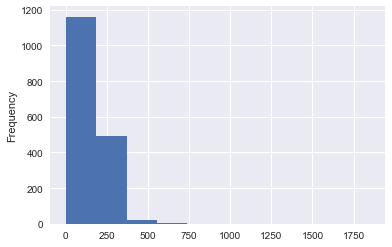

In [50]:
shoe.retailPrice.plot(kind='hist')

In [51]:
shoe[shoe.highestBid > 2000][['shoe', 'colorway', 'name', 'highestBid', 'year']]

,shoe,colorway,name,highestBid,year
264,Adidas Yeezy Boost 350,Turtledove/Blue Grey-White,Turtledove,2050,2015.0
355,Adidas NMD,EQT Yellow/EQT Yellow/FTWR White,Pharrell HU Human Race Yellow,2050,2016.0
377,Jordan 1 Retro,Black/Sport Blue-White,Fragment,3000,2014.0
617,Adidas Yeezy Boost 750,Brown/Carbon White-Light Brown,OG Light Brown,2125,2015.0
1436,Adidas Ultra Boost,Adidas-Ultra-Boost-Miami-Hurricanes,Miami Hurricanes,3037,2016.0
1437,Nike Air Max 90,White/White,Laser NYC,3037,2016.0
1438,Jordan 1 Retro Low OG,Ice Blue/Vachetta Tan-White,Ice Blue,3037,2017.0


In [52]:
shoe[shoe.retailPrice == shoe.retailPrice.max()][['shoe', 'colorway', 'name', 'retailPrice', 'year']]

,shoe,colorway,name,retailPrice,year
1466,Air Yeezy 2,Gold/White,John Geiger x LASCO Golden Child,1850.0,2016.0


In [53]:
shoe.describe()

,retailPrice,year,absChangePercentage,annualHigh,annualLow,averageDeadstockPrice,changePercentage,changeValue,deadstockRangeHigh,deadstockRangeLow,deadstockSold,highestBid,lastSale,lowestAsk,salesLast72Hours,volatility
count,1678.000000,1671.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000
mean,173.237187,2014.791143,0.207031,447.771156,170.617402,284.398093,0.002659,-12.098927,308.246722,208.870083,242.052443,226.871275,258.525030,232.720501,5.754470,0.200755
std,73.141923,3.006590,0.231956,496.095131,138.334165,231.626813,0.310941,104.734459,277.844109,185.742340,461.141675,250.822331,228.802204,199.318783,24.442537,0.136003
min,0.000000,1985.000000,0.000000,50.000000,11.000000,50.000000,-0.666667,-1058.000000,55.000000,-18.000000,1.000000,0.000000,45.000000,0.000000,1.000000,0.000000
25%,140.000000,2014.000000,0.045520,250.000000,100.000000,175.000000,-0.164438,-42.000000,176.000000,113.000000,23.000000,115.000000,150.000000,140.000000,2.000000,0.124386
50%,160.000000,2016.000000,0.137931,330.000000,140.000000,230.000000,0.000000,0.000000,241.500000,168.000000,81.000000,176.000000,200.000000,185.000000,2.000000,0.177539
75%,190.000000,2017.000000,0.302668,471.000000,195.000000,312.750000,0.105676,21.000000,350.000000,246.000000,251.000000,255.000000,300.000000,250.000000,4.000000,0.246952
max,1850.000000,2017.000000,2.529412,8550.000000,1715.000000,3059.000000,2.529412,549.000000,3693.000000,1900.000000,5579.000000,3037.000000,2515.000000,2000.000000,916.000000,1.362362


In [54]:
shoe.head(2)

,brand,category,colorway,name,releaseDate,retailPrice,shoe,title,year,absChangePercentage,...,createdAt,deadstockRangeHigh,deadstockRangeLow,deadstockSold,highestBid,lastSale,lastSaleDate,lowestAsk,salesLast72Hours,volatility
0,Adidas,adidas Yeezy,Core White/Core White/Core White,Calabasas Core White,2017-03-28 23:59:59,120.0,Adidas Yeezy Powerphase,Adidas Yeezy Powerphase Calabasas Core White,2017.0,0.093750,...,2017-03-28T17:45:09+00:00,185,165,2749,229,175,2017-06-18T19:45:58+00:00,149,916,0.059055
1,Adidas,adidas NMD,Core Black/Core Black/Footwear White,OG Black,2017-05-20 23:59:59,150.0,Adidas NMD XR1,Adidas NMD XR1 OG Black,2017.0,0.086957,...,2017-04-27T21:57:59+00:00,183,117,793,180,150,2017-06-18T16:03:09+00:00,149,133,0.217655


In [55]:
shoe.brand.value_counts()

Nike            593
Jordan          570
Adidas          415
Asics            30
Vans             21
Reebok           15
New Balance      11
Diadora           6
Puma              6
Under Armour      5
Saucony           4
Converse          1
Clarks            1
Name: brand, dtype: int64

In [56]:
tops = shoe[(shoe.brand=='Adidas')|(shoe.brand=='Nike')|(shoe.brand=='Jordan')]

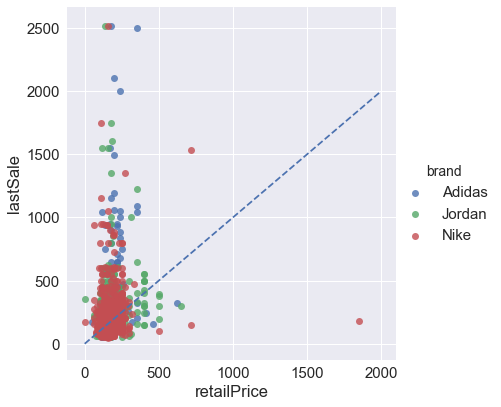

In [59]:
sns.set(font_scale=1.5)
sns.lmplot(x='retailPrice', y ='lastSale', data=tops, hue='brand', fit_reg=False, size=6)
plt.plot(np.linspace(0,2000,2000), np.linspace(0,2000,2000), linestyle='--')
plt.show()

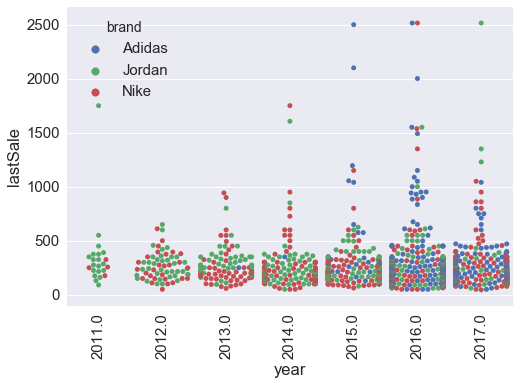

In [60]:
sns.swarmplot(x='year', y='lastSale', data=tops[tops.year>2010], hue='brand')
plt.xticks(rotation=90)
plt.show()

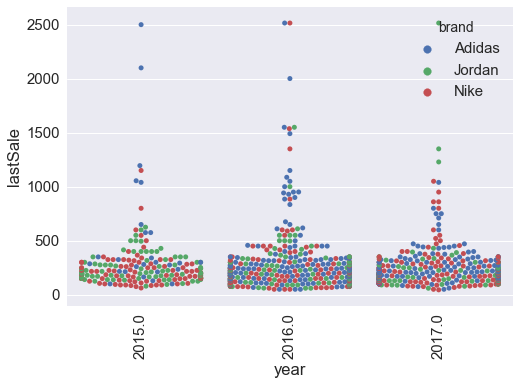

In [61]:
# Adidas didn't come into the market until 2015. Let's look more closely
sns.swarmplot(x='year', y='lastSale', data=tops[tops.year>2014], hue='brand')
plt.xticks(rotation=90)
plt.show()

In [62]:
# Adidas boost's came out in January 2015 along with Yeezy's in February of 2015
tops[(tops.brand=='Adidas') & (tops.shoe.str.contains('boost', case=False))].shape

(170, 25)

In [63]:
# Adidas and Nike Yeezy's
tops[tops.shoe.str.contains('yeezy',case=False)].shape

(28, 25)

In [64]:
# Did Adidas increase market share (on StockX)?
sub_tops = tops[tops.year>2010].groupby(['year', 'brand'])['brand'].count().unstack().fillna(0)
sub_tops = sub_tops.T
sub_tops = sub_tops.div(sub_tops.sum())
sub_tops = sub_tops.T
sub_tops

brand,Adidas,Jordan,Nike
year,,,
2011.0,0.000000,0.826087,0.173913
2012.0,0.000000,0.553846,0.446154
2013.0,0.010309,0.432990,0.556701
2014.0,0.020979,0.454545,0.524476
2015.0,0.132075,0.419811,0.448113
2016.0,0.424242,0.264646,0.311111
2017.0,0.410758,0.210269,0.378973


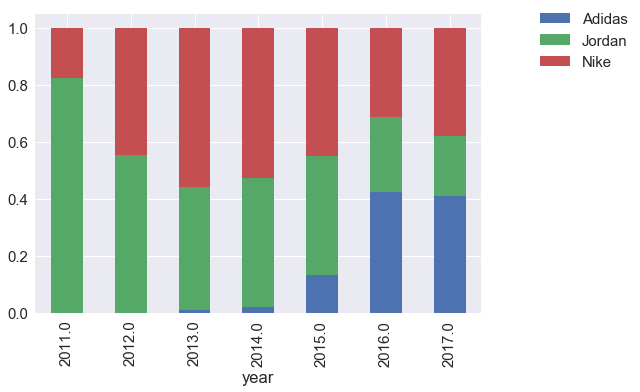

In [65]:
sub_tops.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.1, 1.05))

In [66]:
tops.iloc[:,7:]

,title,year,absChangePercentage,annualHigh,annualLow,averageDeadstockPrice,changePercentage,changeValue,createdAt,deadstockRangeHigh,deadstockRangeLow,deadstockSold,highestBid,lastSale,lastSaleDate,lowestAsk,salesLast72Hours,volatility
0,Adidas Yeezy Powerphase Calabasas Core White,2017.0,0.093750,1190,136,230,0.093750,15,2017-03-28T17:45:09+00:00,185,165,2749,229,175,2017-06-18T19:45:58+00:00,149,916,0.059055
1,Adidas NMD XR1 OG Black,2017.0,0.086957,317,138,195,0.086957,12,2017-04-27T21:57:59+00:00,183,117,793,180,150,2017-06-18T16:03:09+00:00,149,133,0.217655
2,Jordan 4 Retro Motorsports Alternate,2017.0,0.000000,400,130,197,0.000000,0,2017-03-15T22:12:06+00:00,169,141,329,156,155,2017-06-18T19:37:34+00:00,155,126,0.092952
3,Adidas Yeezy Boost 350 V2 Zebra,2017.0,0.075758,3072,500,1380,0.075758,50,2017-01-17T00:28:27+00:00,764,656,2093,850,710,2017-06-18T19:22:44+00:00,690,118,0.075830
4,Jordan 1 Retro Mid New Love (2017),2017.0,0.084906,299,93,150,0.084906,9,2017-05-11T15:34:08+00:00,136,94,837,120,115,2017-06-18T16:21:28+00:00,110,115,0.183292
5,Jordan 13 Retro Black Cat,2017.0,0.029412,369,120,225,-0.029412,-5,2016-10-27T22:00:03+00:00,182,148,1397,160,165,2017-06-18T13:09:30+00:00,165,86,0.100721
6,Adidas Ultra Boost 3.0 Oreo,2017.0,0.104545,344,165,246,-0.104545,-23,2017-01-20T15:05:59+00:00,233,161,2629,197,197,2017-06-18T09:19:38+00:00,205,82,0.183343
7,Jordan 11 Retro Low Barons,2017.0,0.000000,375,110,208,0.000000,0,2017-02-09T15:14:31+00:00,192,138,755,155,165,2017-06-18T17:29:13+00:00,160,72,0.163327
8,Jordan 4 Retro Royalty,2017.0,0.176471,369,120,232,0.176471,24,2017-01-27T23:53:43+00:00,219,101,2033,200,160,2017-06-18T17:08:13+00:00,162,71,0.366558
9,Jordan Defining Moments Pack Last Shot,2017.0,0.025000,900,350,560,-0.025000,-10,2017-04-21T15:22:29+00:00,430,350,165,426,390,2017-06-18T18:55:54+00:00,430,70,0.103298
